<a href="https://colab.research.google.com/github/adi30042005/StockPulse/blob/main/LGBMboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

# load the dataset (assuming it's in csv format)
df = pd.read_csv("retail_store_inventory.csv")


In [ ]:
# convert date column to datetime formattt so we can work with it easily
# some dates may be written in different formats, so we handle that
# `dayfirst=True` ensures that dates like "13-01-2022" are rejad correctly

df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")

# remove any rows where the date couldn't be converteds
df.dropna(subset=["Date"], inplace=True)



In [ ]:
# sort the data so that each store-product combination is arranged in time order
df.sort_values(by=["Store ID", "Product ID", "Date"], inplace=True)

# calculate the average daily sales for each store-product combination
# this helps in estimating how fast inventory is getting sold
avg_sales = df.groupby(["Store ID", "Product ID"])['Units Sold'].mean().reset_index()
avg_sales.rename(columns={"Units Sold": "Avg_Daily_Sales"}, inplace=True)

# merge this new data back into the main dataframe
df = df.merge(avg_sales, on=["Store ID", "Product ID"], how="left")

# estimate the number of days left before stock runs out
# formula: inventory level / average daily sales
# we add a small value (1e-5) to avoid division by zero errror
df["Days_Until_Stockout"] = df["Inventory Level"] / (df["Avg_Daily_Sales"] + 1e-5)

# stockout can't be less than 1 day, so we cap the minimum value at 1
df["Days_Until_Stockout"] = df["Days_Until_Stockout"].clip(lower=1)



In [ ]:
# convert categorical columns (like store id, product id, etc.) into numbers
# this is needed because machine learning models can't work with text data directly
label_encoders = {}
categorical_cols = ["Store ID", "Product ID", "Category", "Region", "Weather Condition", "Seasonality"]
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # convert text labels to numeric values
    label_encoders[col] = le  # store encoders in case we need them later

# choose the columns that will be used as input features
features = ["Store ID", "Product ID", "Category", "Region", "Inventory Level",
            "Units Ordered", "Demand Forecast", "Price", "Discount",
            "Weather Condition", "Holiday/Promotion", "Competitor Pricing", "Seasonality"]

# the target variable we are trying to predict is 'days iuntil stockout'
X = df[features]
y = df["Days_Until_Stockout"]

# split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

# define the lightgbm model
model = lgb.LGBMRegressor(
    objective="regression",  # we are doing regression (predicting a continuous value)
    metric="rmse",  # root mean squared error will be used to evaluate performance
    boosting_type="gbdt",  # gradient boosting decision trees
    learning_rate=0.05,  # how fast the model learns (lower values mean slower but more stable learning)
    num_leaves=31,  # controls model complexity (higher values mean more complexity)
    n_estimators=100  # number of trees in the model
)

# train the model on the training data
# we also evaluate the model on the test set as it trains
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=[lgb.log_evaluation(50)])

# make predictions on the test set
y_pred = model.predict(X_test)

# calculate error metrics to see how well our model is performing
mae = mean_absolute_error(y_test, y_pred)  # average absolute error in predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # root mean squared error
r2 = r2_score(y_test, y_pred)  # how well the model explains the variance in data

# print the results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1247
[LightGBM] [Info] Number of data points in the train set: 58480, number of used features: 13
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.072498
[50]	valid_0's rmse: 0.0956172
[100]	valid_0's rmse: 0.0472867
Mean Absolute Error (MAE): 0.0352
Root Mean Squared Error (RMSE): 0.0473
R² Score: 0.9971


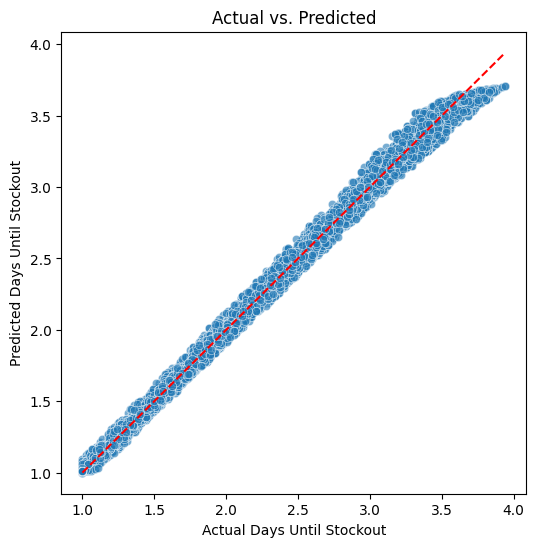

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# actual vs. predicted scatter plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual Days Until Stockout")
plt.ylabel("Predicted Days Until Stockout")
plt.title("Actual vs. Predicted")
plt.show()



In [ ]:
# Variance of 'Days_Until_Stockout'
print("Variance:", df["Days_Until_Stockout"].var())


Variance: 0.7581840808240444


In [ ]:
#memory effecient, processing fficiency is approx 10 times more comparted to XGboost

In [ ]:
# import pandas as pd
# import lightgbm as lgb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.preprocessing import LabelEncoder
# import numpy as np

# # load the dataset (assuming it's in csv format)
# df = pd.read_csv("retail_store_inventory.csv")


# # convert date column to datetime formattt so we can work with it easily
# # some dates may be written in different formats, so we handle that
# # `dayfirst=True` ensures that dates like "13-01-2022" are rejad correctly

# df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")

# # remove any rows where the date couldn't be converteds
# df.dropna(subset=["Date"], inplace=True)



# # sort the data so that each store-product combination is arranged in time order
# df.sort_values(by=["Store ID", "Product ID", "Date"], inplace=True)

# # calculate the average daily sales for each store-product combination
# # this helps in estimating how fast inventory is getting sold
# avg_sales = df.groupby(["Store ID", "Product ID"])['Units Sold'].mean().reset_index()
# avg_sales.rename(columns={"Units Sold": "Avg_Daily_Sales"}, inplace=True)

# # merge this new data back into the main dataframe
# df = df.merge(avg_sales, on=["Store ID", "Product ID"], how="left")

# # estimate the number of days left before stock runs out
# # formula: inventory level / average daily sales
# # we add a small value (1e-5) to avoid division by zero errror
# df["Days_Until_Stockout"] = df["Inventory Level"] / (df["Avg_Daily_Sales"] + 1e-5)

# # stockout can't be less than 1 day, so we cap the minimum value at 1
# df["Days_Until_Stockout"] = df["Days_Until_Stockout"].clip(lower=1)



# # convert categorical columns (like store id, product id, etc.) into numbers
# # this is needed because machine learning models can't work with text data directly
# label_encoders = {}
# categorical_cols = ["Store ID", "Product ID", "Category", "Region", "Weather Condition", "Seasonality"]
# for col in categorical_cols:
#     le = LabelEncoder()
#     df[col] = le.fit_transform(df[col])  # convert text labels to numeric values
#     label_encoders[col] = le  # store encoders in case we need them later

# # choose the columns that will be used as input features
# features = ["Store ID", "Product ID", "Category", "Region", "Inventory Level",
#             "Units Ordered", "Demand Forecast", "Price", "Discount",
#             "Weather Condition", "Holiday/Promotion", "Competitor Pricing", "Seasonality"]

# # the target variable we are trying to predict is 'days iuntil stockout'
# X = df[features]
# y = df["Days_Until_Stockout"]

# # split the data into training and testing sets (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# # define the lightgbm model
# model = lgb.LGBMRegressor(
#     objective="regression",  # we are doing regression (predicting a continuous value)
#     metric="rmse",  # root mean squared error will be used to evaluate performance
#     boosting_type="gbdt",  # gradient boosting decision trees
#     learning_rate=0.05,  # how fast the model learns (lower values mean slower but more stable learning)
#     num_leaves=31,  # controls model complexity (higher values mean more complexity)
#     n_estimators=100  # number of trees in the model
# )

# # train the model on the training data
# # we also evaluate the model on the test set as it trains
# model.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=[lgb.log_evaluation(50)])

# # make predictions on the test set
# y_pred = model.predict(X_test)

# # calculate error metrics to see how well our model is performing
# mae = mean_absolute_error(y_test, y_pred)  # average absolute error in predictions
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # root mean squared error
# r2 = r2_score(y_test, y_pred)  # how well the model explains the variance in data

# # print the results
# print(f"Mean Absolute Error (MAE): {mae:.4f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
# print(f"R² Score: {r2:.4f}")


# import matplotlib.pyplot as plt
# import seaborn as sns

# # actual vs. predicted scatter plot
# plt.figure(figsize=(6, 6))
# sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
# plt.xlabel("Actual Days Until Stockout")
# plt.ylabel("Predicted Days Until Stockout")
# plt.title("Actual vs. Predicted")
# plt.show()

